# Trabajo Practico 1 - Que No Se Escape Nadie (?)

# Introduccion:

En el presente trabajo se analizara una base de datos de la empresa FIUBAFIP con el objetivo de entender la informacion que fue recolectada y poder predecir aquellas personas que tiene alto o bajo poder adquisitivo. 

### Objetivos:

- Entender la base de datos.
- Ver cómo los datos se relacionan entre si.
- Poder sacar alguna conclusión o descubrir un patrón a partir de estos.
- Indicar cuáles son los factores más importantes que determinan el poder adquisitivo de una persona.
- Poder llegar a armar un baseline

## Bibliotecas utilizadas:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

## Feature enginner:

In [2]:
GSPREADHSEET_DOWNLOAD_URL = ("https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format)
FIUFIP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_GID), skiprows=0)

Antes de iniciar una analisis sobre unos datos, debemos verificar que no contiene informacion invalida o que no sea util para el analisis.

Inicialmente buscaremos missings (atributos que no fueron cargados).

In [3]:
df.isna().any()

anios_estudiados                              False
barrio                                         True
categoria_de_trabajo                           True
edad                                          False
educacion_alcanzada                           False
estado_marital                                False
ganancia_perdida_declarada_bolsa_argentina    False
genero                                        False
horas_trabajo_registradas                     False
religion                                      False
rol_familiar_registrado                       False
tiene_alto_valor_adquisitivo                  False
trabajo                                        True
dtype: bool

Como podemos ver existen 3 campos en donde no tenemos la informacion de todas las instancias. Por lo que ahora deberemos analizar cada situacion y tomar un criterio para decidir que hacer con estos instancias con valores invalidos.

Con este script podemos ver cuantas instancias tiene nulos y en que campos. De esta manera vemos que existe 27 personas que no completar las columans barrio, categoria_de_trabajo y trabajo. Al ser un grupo pequeño y tener valores invalidos en categoria que a priori parecen ser relevantes (categoria_de_trabajo y trabajo) decidimos descartalos.

In [4]:
def tiene_n_missings(x, n):
    acum = 0
    for i in range(len(x)):
        if x[i]:
            acum += 1
    return n <= acum


lista_de_missings = [tiene_n_missings(x, 3) for x in df.isna().to_numpy()]

df_3_missings = df.reset_index()[lista_de_missings].set_index('index')
df_3_missings.isnull().sum()

anios_estudiados                               0
barrio                                        27
categoria_de_trabajo                          27
edad                                           0
educacion_alcanzada                            0
estado_marital                                 0
ganancia_perdida_declarada_bolsa_argentina     0
genero                                         0
horas_trabajo_registradas                      0
religion                                       0
rol_familiar_registrado                        0
tiene_alto_valor_adquisitivo                   0
trabajo                                       27
dtype: int64

In [5]:
df.drop(df_3_missings.index, inplace = True)

Luego hacemos la misma logica para analizar a las personas con 2 campos nulos 

In [6]:
lista_de_missings = [tiene_n_missings(x, 2) for x in df.isna().to_numpy()]

df_2_missings = df.reset_index()[lista_de_missings].set_index('index')
df_2_missings.isnull().sum()

anios_estudiados                                 0
barrio                                           0
categoria_de_trabajo                          1809
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1809
dtype: int64

Podemos notar que existen una gran cantidad de personas que no contesto cual es su trabajo. Como inicialmente el campo trabajo es una valor a tener en cuenta para poder decidir el valor adquisitivo decidimos crear un nuevo campo "No contesto" para no tener que descartar todos estos datos.

In [7]:
df = df.replace({'trabajo': np.nan, 'categoria_de_trabajo': np.nan},'No contesto')
df['trabajo'].isna().any() 

False

Por ultimo nos queda analizar cuantas son las instancias con un Nan. 

Como podemos ver existen 556 personas que no completaron su barrio. En esta ocasion decidimos analizar la cantidad de personas que viven en todos los barrios. Podemos notar que mas de un 90% vive en Palermo por lo que nos resulto correcto incluir a estas instancias en este barrio.

In [8]:
lista_de_missings = [tiene_n_missings(x, 1) for x in df.isna().to_numpy()]

df_missing = df.reset_index()[lista_de_missings].set_index('index')
df_missing.isnull().sum()

anios_estudiados                                0
barrio                                        556
categoria_de_trabajo                            0
edad                                            0
educacion_alcanzada                             0
estado_marital                                  0
ganancia_perdida_declarada_bolsa_argentina      0
genero                                          0
horas_trabajo_registradas                       0
religion                                        0
rol_familiar_registrado                         0
tiene_alto_valor_adquisitivo                    0
trabajo                                         0
dtype: int64

In [9]:
df['barrio'].value_counts(normalize = True)

Palermo                0.912190
Belgrano               0.020108
San Isidro             0.006192
Villa Urquiza          0.004284
Recoleta               0.003784
La Boca                0.003565
Agronomia              0.003315
Almagro                0.003127
Balvanera              0.002971
Puerto Madero          0.002814
Caballito              0.002533
Boedo                  0.002502
Barracas               0.002345
Chacarita              0.002283
Coghland               0.002189
Floresta               0.002095
Constitucion           0.002001
Colegiales             0.001939
Flores                 0.001876
Liniers                0.001845
Monte Castro           0.001595
Mataderos              0.001376
Nueva Pompeya          0.001345
Monserrat              0.001157
nuñez                  0.001063
Parque Chacabuco       0.000969
Parque Avellaneda      0.000907
Villa Luro             0.000907
Parque Chas            0.000876
La Paternal            0.000751
Retiro                 0.000625
Villa De

In [10]:
df = df.replace({'barrio': np.nan},'Palermo')

Al hacer este analsis notamos la gran cardinalidad de la variable barrio. Para poder analizar mas facilmente esta variable decidimos agrupar a los disintos barrios por sus comunas.

In [11]:
mapa = {'Palermo' : 'C14','Belgrano' : 'C13','San Isidro' : 'San Isidro','Villa Urquiza' : 'C12','Recoleta' : 'C2','La Boca' : 'C4','Agronomia' : 'C15','Almagro' : 'C5','Balvanera' : 'C3','Puerto Madero' : 'C1','Caballito' : 'C6','Boedo' : 'C5','Barracas' : 'C4','Chacarita' : 'C15','Coghland' : 'C12','Floresta' : 'C10','Constitucion' : 'C1','Colegiales' : 'C13','Flores' : 'C7','Liniers' : 'C9','Monte Castro' : 'C10','Mataderos' : 'C9','Nueva Pompeya' : 'C4','Monserrat' : 'C1','nuñez' : 'C13','Parque Chacabuco' : 'C7','Parque Avellaneda' : 'C9','Villa Luro' : 'C10','Parque Chas' : 'C15','La Paternal' : 'C15','Retiro' : 'C1','Villa Devoto' : 'C11','Villa Soldati' : 'C8','San Telmo' : 'C1','Villa Real' : 'C10','Santa Rita' : 'C11','Villa General Mitre' : 'C11','Versalles' : 'C10','Velez Sarsfield' : 'C10','Villa Pueyrredon' : 'C12','Cilla Riachuelo' : 'C8'}
df['comuna'] = df['barrio'].apply(lambda x: mapa.get(x))

Notamos que existe un grupo de gente que apesar de figurar como sin trabajo tiene un numero mayor a cero de horas_de_trabajo_registrada. Decidimos descartarlas por ser instancias con informacion contradictoria.

In [12]:
df_gente_sin_trabajo_con_horas_registradas = df[(df['categoria_de_trabajo'] == 'sin_trabajo') & (df['horas_trabajo_registradas'] > 0)]
df.drop(df_gente_sin_trabajo_con_horas_registradas.index, inplace = True)

Luego analizando las variables por separadado encontramos que para dos variables distintas existen dos categorias similares, las cueles presentan la misma distribucion pero una de ellas con una varianza mayor debido a tener pocas muestras.

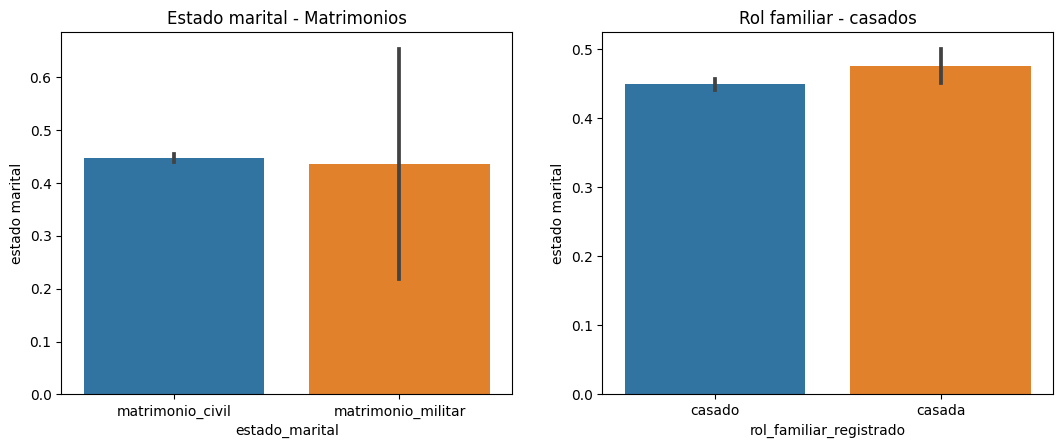

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)
sns.barplot(
    data=df[(df['estado_marital'] == 'matrimonio_civil') | (df['estado_marital'] == 'matrimonio_militar')],
    y='tiene_alto_valor_adquisitivo',
    x='estado_marital', ax=axes[0])

axes[0].set_title("Estado marital - Matrimonios")
axes[0].set_ylabel("estado marital")

sns.barplot(
    data=df[(df['rol_familiar_registrado'] == 'casado') | (df['rol_familiar_registrado'] == 'casada')],
    y='tiene_alto_valor_adquisitivo',
    x='rol_familiar_registrado', ax=axes[1])

axes[1].set_title("Rol familiar - casados")
axes[1].set_ylabel("estado marital")

plt.show()

Como podemos observar en los graficos la informacion que aporta para estimar a la funcion target, el matrimonio civil y el militar es exactamente la misma (lo mismo ocurre para cadao y casada). Es por ello que decidimos combinarlas en una misma categoria.

In [14]:
df['rol_familiar_registrado'] = df['rol_familiar_registrado'].apply(lambda x: 'casado' if x == 'casada' else x)
df['estado_marital'] = df['estado_marital'].apply(lambda x: 'matrimonio' if x == 'matrimonio_civil' or x == 'matrimonio_militar' else x)

## Analisis de los datos:


## Observaciones:

## Conclusion:

## Baseline: